# Traffic Sign Recognition

The Dataset: 

# Initialization

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pathlib
import os
import timeit
import itertools
import datetime

# Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Model
# metrics
import tensorflow_addons as tfa 

# cv2
import cv2

# sklearn
from sklearn.metrics import confusion_matrix

# MLOps
import wandb
from wandb.keras import WandbCallback

# General Parameters

In [2]:
# get num of classes
def get_num_classes(path):
    num_cats = 0
    for fname in os.listdir(path):
        try:
            bool = type(int(fname)) is int
            num_cats +=1
        except:
            pass
    return num_cats

In [3]:
# location of the data
base_dir = './dataset/GTSRB'
train_dir = './dataset/GTSRB/Train'
test_dir = './dataset/GTSRB/Test'

# dataset metadata
train_meta = './dataset/GTSRB/Train.csv'
test_meta = './dataset/GTSRB/Test.csv'

## Helper Functions

In [4]:
def plot_results(history, simple_style=False):
    # Results analysis:
    if simple_style:
        losses = pd.DataFrame(history.history, columns=['loss', 'val_loss'])
        accuracies = pd.DataFrame(history.history, columns=['acc', 'val_acc'])
        losses.plot()
        accuracies.plot()
    else:
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(1, len(acc) + 1)

        plt.plot(epochs, acc, color='blue', label='Training acc')
        plt.plot(epochs, val_acc, color='gray', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure()

        plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
        plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()

        plt.show()

# plots images with labels within jupyter notebook
# source: https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py#L79

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

# plot Confusion Matrix
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# plot a test image

def get_input_img(sign_class, img_height, img_width, index = 0, dataset='Test'):
    def reshape_img(img):
        img = cv2.resize(img, (img_height,img_width))
        return np.expand_dims(img, axis=0)

    if dataset == 'Train':
        file_path = base_dir + '/Train/' + str(sign_class) + '/'
        file_name = os.listdir(file_path)[index]
        img = cv2.imread(file_path + file_name)
    
    if dataset == 'Test':
        meta = pd.read_csv('./dataset/GTSRB/Test.csv')
        file = meta[meta['ClassId'] == sign_class]['Path'].values[index]
        img = cv2.imread(base_dir + '/' + file)        

    plt.figure(figsize=(3,3))
    plt.imshow(img)
    return reshape_img(img)
        

def plot_feature_maps(model, img):
    successive_outputs = [layer.output for layer in model.layers[1:]]
    inputs = model.inputs
    outputs = successive_outputs
    filters = Model(inputs=inputs, outputs=outputs)
    feature_maps = filters.predict(img)
    layer_names = [layer.name for layer in model.layers]
    for layer_name, feature_map in zip(layer_names, feature_maps):
        print(feature_map.shape)
        if len(feature_map.shape) == 4:
            # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
            n_features = feature_map.shape[-1]  # number of features in the feature map
            size = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
            # We will tile our images in this matrix
            display_grid = np.zeros((size, size * n_features))
            
            for i in range(n_features):
                x = feature_map[0, :, :, i]
                x -= x.mean()
                x /= x.std()
                x *= 64
                x += 128
                x = np.clip(x, 0, 255).astype('uint8')
                display_grid[:, i * size : (i + 1) * size] = x

            #Display the grid
            scale = 20. / n_features
            plt.figure( figsize=(scale * n_features, scale) )
            plt.title ( layer_name )
            plt.grid  ( False )
            plt.imshow( display_grid, aspect='auto', cmap='viridis' )
        

## MLOps

Weights an Biases init

In [5]:
!wandb login

wandb: Currently logged in as: gaspia (use `wandb login --relogin` to force relogin)


In [6]:
#Generic dataset parameters
img_width, img_height = 48, 48
batch_size = 256
cat_num = get_num_classes(train_dir)

# Dataset exploration and preprocessing

## Simple Keras based data augmentation

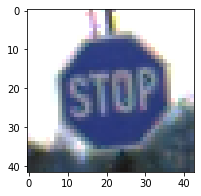

In [7]:
# loading an image sample
img = get_input_img(sign_class=14, img_height=img_height, img_width=img_width, index=31, dataset='Train')

def plot_augmented_samples (batch):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
    # generate batch of images
    for i in range(3):
	    # convert to unsigned integers
	    image = next(aug_iter)[0].astype('uint8')
	    # plot image
	    ax[i].imshow(image)
	    ax[i].axis('off')
    

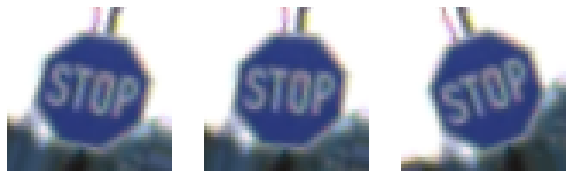

In [8]:
# image rotation
datagen = ImageDataGenerator(rotation_range=30, fill_mode='nearest')
# iterator
aug_iter = datagen.flow(img, batch_size=1)
plot_augmented_samples(aug_iter)

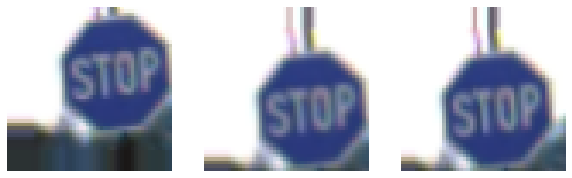

In [9]:
# height and width of the image
datagen = ImageDataGenerator(width_shift_range=.2, 
        height_shift_range=.2,
        fill_mode='nearest'
        )
# iterator
aug_iter = datagen.flow(img, batch_size=1)
plot_augmented_samples(aug_iter)

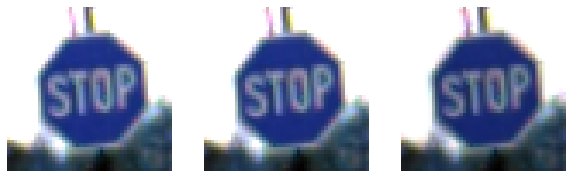

In [10]:
# brightness
datagen = ImageDataGenerator(brightness_range=[1,1.2])
# iterator
aug_iter = datagen.flow(img, batch_size=1)
plot_augmented_samples(aug_iter)

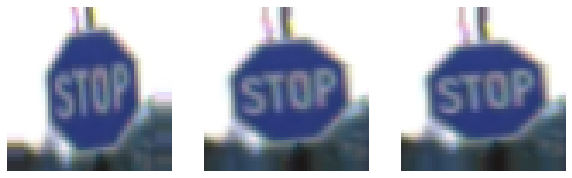

In [11]:
# zoom
datagen = ImageDataGenerator(zoom_range=0.2)  # zoom
# iterator
aug_iter = datagen.flow(img, batch_size=1)
plot_augmented_samples(aug_iter)

/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


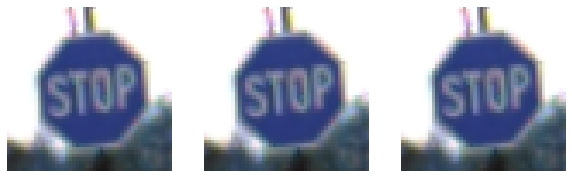

In [12]:
# ZCA whitening
datagen = ImageDataGenerator(zca_whitening=True)  # zoom
# iterator
aug_iter = datagen.flow(img, batch_size=1)
plot_augmented_samples(aug_iter)

NOTE:
- We opt not to use zoom as it will distort the sign shapes
- We also opt not to horizontal and vertical flips and signs have directional information which would be lost

Found 27447 images belonging to 43 classes.


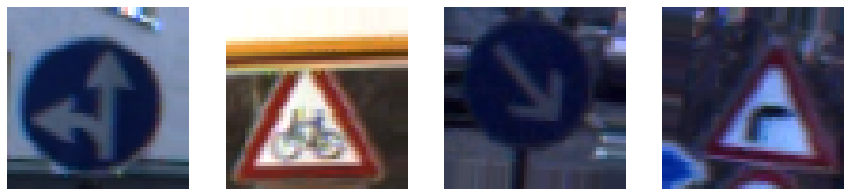

In [13]:
# dry running the generator and fine-tunning the parameters

train_datagen = ImageDataGenerator(validation_split=0.3, 
    # we will not use vertical/horizontal flip as signs have directional information that is revelant
    # adding a img rotation of up to 20º
    rotation_range=10,
    # adding a img translation of up to 20% of the image size - We found some issues with the fill mode = 'nearest'
    width_shift_range=.1, 
    height_shift_range=.1,
    fill_mode='nearest',
    # adding a brightness range of 1 to 1.2 - after visual inspection
    brightness_range=[1,1.2]
    # zoom
    #zoom_range=0.2,
    #zca_whitening
    )
        
train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset='training',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',    
    shuffle=True,
    class_mode='categorical'
    )

# plotting a sample from the training dataset
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
for i in range(4):

  # convert to unsigned integers for plotting
  image = next(train_generator)[0].astype('uint8')

  # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
  image = np.squeeze(image[0])

  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].axis('off')


In [14]:
# training dataset
# With Keras data augmentation

def get_train_val_data(train_dir, img_width, img_height, batch_size, seed):
        #training dataset
    train_datagen = ImageDataGenerator(validation_split=0.3, 
        # we will not use vertical/horizontal flip as signs have directional information that is revelant
        # adding a img rotation of up to 20º
        rotation_range=10,
        # adding a img translation of up to 20% of the image size - We found some issues with the fill mode = 'nearest'
        width_shift_range=.1, 
        height_shift_range=.1,
        fill_mode='nearest',
        # adding a brightness range of 1 to 1.2 - after visual inspection
        brightness_range=[1,1.2],
        # zoom
        #zoom_range=0.2,
        rescale=1./255)
        
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        subset='training',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',    
        shuffle=True,
        seed=seed,
        class_mode='categorical')

    # validation dataset
    val_generator = train_datagen.flow_from_directory(
        train_dir,
        subset='validation',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',    
        seed=seed,
        class_mode='categorical'
        )

    return train_generator, val_generator

def get_test_data(test_dir, labels_path, img_width, img_height, batch_size):
    #test dataset
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(labels_path, dtype=str),
        directory = test_dir,
        x_col = 'Path',
        y_col = 'ClassId',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='categorical'
        )
    
    return test_generator

In [15]:
train_generator, val_generator = get_train_val_data(train_dir, img_width, img_height, batch_size, seed=1)

Found 27447 images belonging to 43 classes.
Found 11762 images belonging to 43 classes.


In [16]:
test_generator = get_test_data(base_dir, test_meta, img_width, img_height, batch_size)

Found 12630 validated image filenames belonging to 43 classes.


In [17]:
print('Batches train=%d, test=%d' % (len(train_generator), len(test_generator)))

Batches train=108, test=50


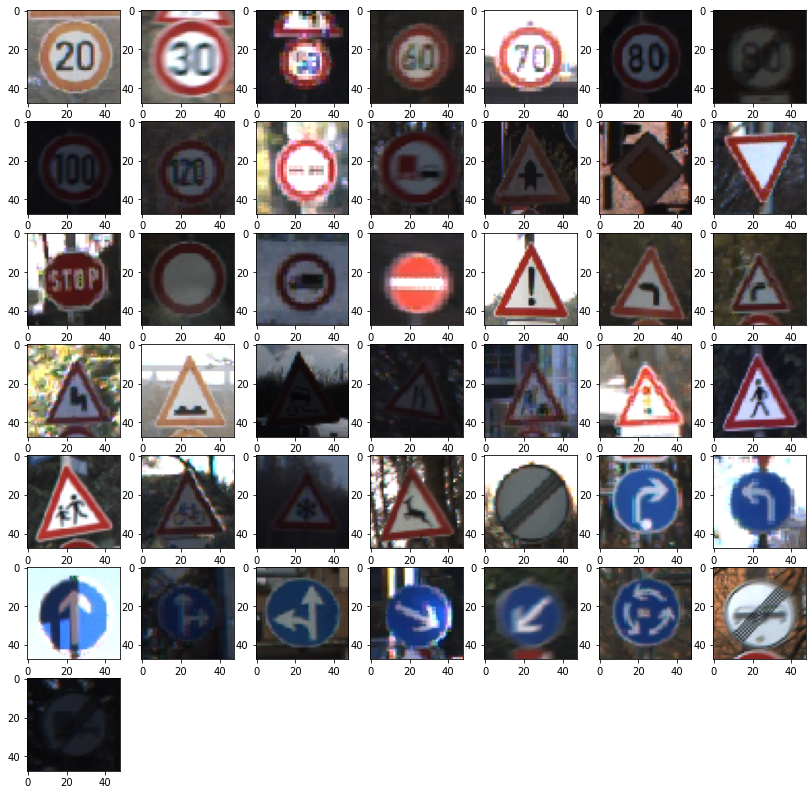

In [18]:
# Visualizing all the different Signs
img_dir = pathlib.Path(train_dir)
plt.figure(figsize=(14,14))
index = 0
for i in range(cat_num):
    plt.subplot(7, 7, i+1)
    plt.grid(False)
    sign = list(img_dir.glob(f'{i}/*'))[0]
    img = load_img(sign, target_size=(img_width, img_height))
    plt.imshow(img)
plt.show()

## Class Distribution

In [19]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

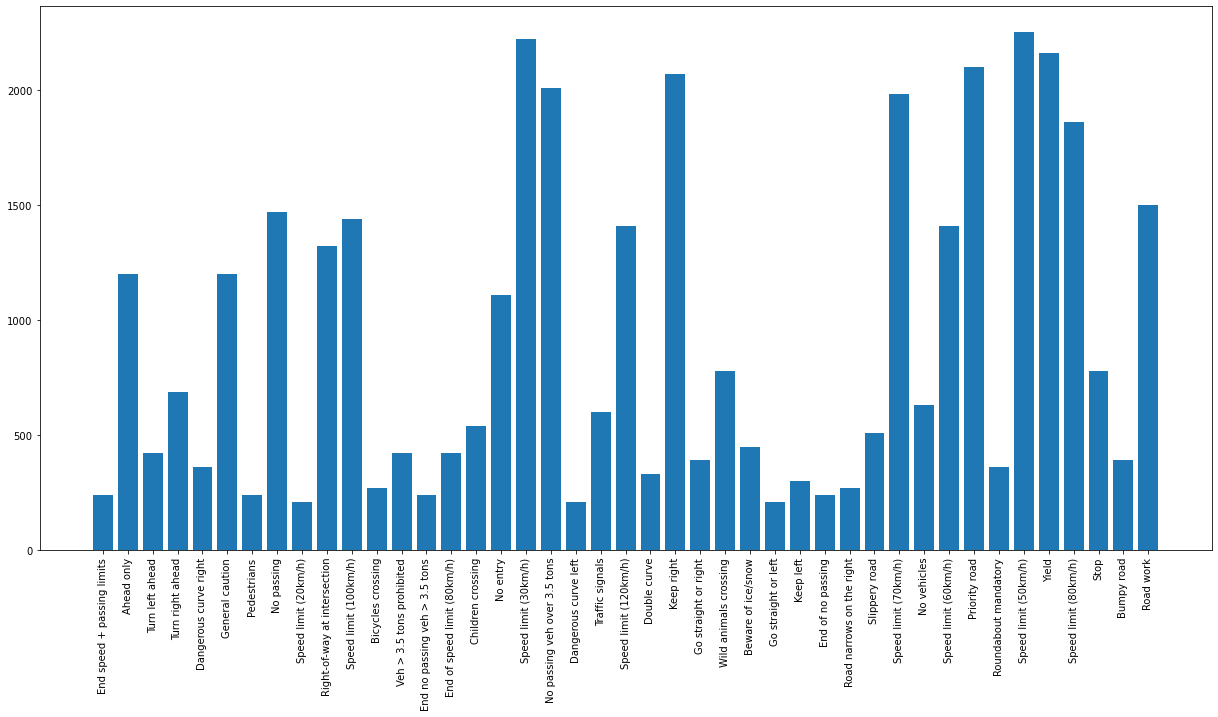

In [20]:
# determining the training data distribution per category
folders = next(os.walk(train_dir))[1]

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_dir + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

In [21]:
# Calculating the weights to compensate for the class imbalance
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
        class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)

class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
class_weights

{0: 4.342192691029901,
 1: 0.4107479572595852,
 2: 0.45366192294342245,
 3: 0.6908033826638478,
 4: 0.43421926910299,
 5: 0.4221576227390181,
 6: 1.1690518783542039,
 7: 1.4473975636766334,
 8: 2.1710963455149503,
 9: 0.8214959145191704,
 10: 0.7598837209302326,
 11: 4.342192691029901,
 12: 0.40527131782945736,
 13: 2.5329457364341086,
 14: 2.763213530655391,
 15: 2.3381037567084078,
 16: 1.7879616963064295,
 17: 3.3772609819121446,
 18: 0.607906976744186,
 19: 1.5197674418604652,
 20: 3.7994186046511627,
 21: 1.6886304909560723,
 22: 3.3772609819121446,
 23: 0.6467095497278575,
 24: 2.026356589147287,
 25: 1.1690518783542039,
 26: 3.7994186046511627,
 27: 1.321536905965622,
 28: 2.1710963455149503,
 29: 0.7598837209302326,
 30: 2.3381037567084078,
 31: 4.342192691029901,
 32: 0.44051230198854063,
 33: 3.0395348837209304,
 34: 0.4605355884425652,
 35: 2.5329457364341086,
 36: 3.7994186046511627,
 37: 3.7994186046511627,
 38: 0.49024756189047264,
 39: 2.1710963455149503,
 40: 0.63323643

## Analysis of the dataset

1. We can tell the image size is 
2. Some of the images have issues with low lighting / contrast / saturation which may become a problem for the model
3. The data is highly unbalanced

# Model Architectures

## Generic Paramters

In [22]:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num,
    "class_weights": True
}

## Baseline

The first CNN we are going to build consists on the following: 
1. A Convolutional layer followed by a MaxPooling layer; 
2. A second Convolutional layer followed by another MaxPooling layer; 
3. A Flatten layer (this is the input layer for the fully connected part of the CNN); 
4. A Dense Layer (this is the first hidden layer for the fully connected part of the CNN)
5. A second Dense layer (this is the output layer for the fully connected part of the CNN).
<br>

Please be mindful regarding the details below:
- The first and second Convolutional layers should contain 32 neurons (filters), with a filter of size 3x3 and an input shape of 64x64x3;
- The first and second MaxPooling layer should have a size of 2x2;
- The first Dense layer should have 128 neurons and the activation function should be the relu, while the second Dense layer should contain 1 neuron and the softmax as the activation function.

In [ ]:
baseline_model = Sequential()
# Refference: DLNN lecture week 6
baseline_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid', input_shape=(img_width, img_height, 3)))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))
baseline_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))
# MLP - input layer
baseline_model.add(Flatten())
# MLP - hidden layer
baseline_model.add(Dense(units=128, activation=relu))
# MLP - output layer
baseline_model.add(Dense(units=43, activation=softmax))

# Check built model:
baseline_model.summary()

### Training And Evaluating The Model

In [ ]:
# adding f1-score
import tensorflow_addons as tfa 

f1 = tfa.metrics.F1Score(num_classes=cat_num, average='weighted' or 'macro' or 'samples')

In [ ]:
from tensorflow.keras import optimizers 
# adding a tunned Adam optimizer with learning rate = 0.001 as a tunnable HYP
opt = Adam(learning_rate=0.01)

baseline_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc', f1])

In [ ]:
# Common attributes:
mlops_config['steps_per_epoch'] = 5
mlops_config['epochs'] = 100
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'categorical_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['metrics'] = ['acc', 'f1']

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 8
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=True)

In [ ]:
# MLOps init and callback
wandb.init(name='CNN_TS_baseline_b256_e100_DA_CW' , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_baseline = baseline_model.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    class_weight=class_weights,
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})

wandb.finish()

In [ ]:
plot_results(history_baseline)

In [ ]:
# predictions on Test data

Y_pred = baseline_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_pred, test_generator.classes, target_names=list(classes.values())))

In [ ]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 3, 'Test')
print ('Shape before entering the conv layer:', img.shape)

In [ ]:
plot_feature_maps(baseline_model, img)

## 7 layer model

Refference: Masci, et al "A committee of neural networks for traffic sign classification" [1]

In [ ]:
masci_model = Sequential()
# Refference: DLNN lecture week 6
masci_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid', input_shape=(img_width, img_height, 3)))
masci_model.add(MaxPooling2D(pool_size=(2, 2)))
masci_model.add(Conv2D(filters=32, kernel_size = (4, 4), strides = (1,1), activation = relu, padding = 'valid'))
masci_model.add(MaxPooling2D(pool_size=(2, 2)))
masci_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
masci_model.add(MaxPooling2D(pool_size=(2, 2)))
# MLP - input layer
masci_model.add(Flatten())
# MLP - hidden layer
masci_model.add(Dense(units=200, activation=relu))
# MLP - output layer
masci_model.add(Dense(units=43, activation=softmax))

# Check built model:
masci_model.summary()

In [ ]:
# adding f1-score
from tensorflow.keras import optimizers 
import tensorflow_addons as tfa 

f1 = tfa.metrics.F1Score(num_classes=cat_num, average='weighted' or 'macro' or 'samples')

# adding a tunned Adam optimizer with learning rate = 0.001 as a tunnable HYP
opt = Adam(learning_rate=0.01)

masci_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc', f1])

In [ ]:
# Common attributes:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num,
    "class_weights": True
}

mlops_config['steps_per_epoch'] = 5
mlops_config['epochs'] = 100
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'categorical_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['learning_rate'] = 0.01,
mlops_config['metrics'] = ['acc', f1]

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 8
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=True)

In [ ]:
# MLOps init and callback
wandb.init(name='CNN_TS_masci_b256_e100' , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_masci_model = masci_model.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    class_weight=class_weights,
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})

wandb.finish()

In [ ]:
plot_results(history_masci_model)

In [ ]:
# predictions on Test data

Y_pred = masci_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_pred, test_generator.classes, target_names=list(classes.values())))

In [ ]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 30, 'Test')
print ('Shape before entering the conv layer:', img.shape)

In [ ]:
plot_feature_maps(masci_model, img)


## Small Scale Model

Refference: Chaudhari (et, al) "Traffic Sign Recognition Using Small-Scale Convolutional Neural Network"

In [ ]:
lwm_model = Sequential()
# MLP - input layer
lwm_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid', input_shape=(img_width, img_height, 3)))
lwm_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model.add(MaxPooling2D(pool_size=(2, 2)))
lwm_model.add(Dropout(0.25))
lwm_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model.add(MaxPooling2D(pool_size=(2, 2)))
lwm_model.add(Dropout(0.25))
# MLP layer
lwm_model.add(Flatten())
lwm_model.add(Dense(units=256, activation=relu))
lwm_model.add(Dropout(0.25))
lwm_model.add(Dense(units=43, activation=softmax))


# Check built model:
lwm_model.summary()

In [ ]:
# Common attributes:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num,
    "class_weights": True
}

mlops_config['steps_per_epoch'] = 10
mlops_config['epochs'] = 1000
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'categorical_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['metrics'] = ['acc', 'f1']
mlops_config['learning_rate'] = 0.01


In [ ]:
# adding f1-score
from tensorflow.keras import optimizers 
import tensorflow_addons as tfa 

f1 = tfa.metrics.F1Score(num_classes=cat_num, average='weighted' or 'macro' or 'samples')

# adding a tunned Adam optimizer with learning rate = 0.001 as a tunnable HYP
opt = Adam(learning_rate=0.01)

masci_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc', f1])

In [ ]:
from tensorflow.keras import optimizers 

lwm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', f1 ])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 10
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=True)

In [ ]:
# MLOps init and callback
wandb.init(name='CNN_TS_lwm_b256_e100_DA_CW' , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_lwm_model = lwm_model.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    class_weight=class_weights,
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})

wandb.finish()

In [ ]:
plot_results(history_lwm_model)

In [ ]:
# predictions on Test data

Y_pred = lwm_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_pred, test_generator.classes, target_names=list(classes.values())))

In [ ]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 30, 'Test')
print ('Shape before entering the conv layer:', img.shape)

In [ ]:
plot_feature_maps(lwm_model, img)

### Improving on LWM

- From the initial results we can assume:
  - ConvLayer:
    - Although the 1st Conv Layer shows definitely more information than the other models, we still lack accuracy on both validation and test set
    - From the feature maps, as soon as we notice that the early application of the droput layer, may be causing the loss of too much information in an early stage
      - Remove the 1st droput layer to increase the information obatined by the model
      - Use Droput only at the MLP layers
    - We will add a second conv layer similar to the 1st one but increase the kernel sizes to 5x5 and work with the kernel numbers
    - to compensate for the information increase we will reduce the number of kernels
    - MLP keeping the same 

Results: Model training is slower

### Config used for model 2

lwm_model2 = Sequential()
##### Conv - input layer
lwm_model2.add(Conv2D(filters=8, kernel_size = (5, 5), strides = (1,1), activation = relu, padding = 'valid', input_shape=(img_width, img_height, 3)))
lwm_model2.add(Conv2D(filters=16, kernel_size = (5, 5), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model2.add(MaxPooling2D(pool_size=(2, 2)))
lwm_model2.add(Conv2D(filters=16, kernel_size = (5, 5), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model2.add(Conv2D(filters=32, kernel_size = (5, 5), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model2.add(MaxPooling2D(pool_size=(2, 2)))
lwm_model2.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model2.add(Conv2D(filters=64, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model2.add(MaxPooling2D(pool_size=(2, 2)))
lwm_model2.add(Dropout(0.25))
##### MLP layer
lwm_model2.add(Flatten())
lwm_model2.add(Dense(units=256, activation=relu))
lwm_model2.add(Dropout(0.25))
lwm_model2.add(Dense(units=43, activation=softmax))

#### Config used for model 3

- to improve the model accuracy:
  - Add additional Conv layer
  - increase the number of kernels
  - increase the MLP sizes

Result: Model starts to overfit after aprox, 20 epocs


### Config used for model 4

- to improve the model accuracy:
  - Add Dropout after 1 conv layer
  - increase the number of kernels

Result: Model starts to overfit after aprox, 20 epocs




In [ ]:
lwm_model2 = Sequential()
# MLP - input layer
lwm_model2.add(Conv2D(filters=8, kernel_size = (5, 5), strides = (1,1), activation = relu, padding = 'valid', input_shape=(img_width, img_height, 3)))
lwm_model2.add(Conv2D(filters=16, kernel_size = (5, 5), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model2.add(MaxPooling2D(pool_size=(2, 2)))
lwm_model2.add(Conv2D(filters=16, kernel_size = (5, 5), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model2.add(Conv2D(filters=32, kernel_size = (5, 5), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model2.add(MaxPooling2D(pool_size=(2, 2)))
lwm_model2.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model2.add(Conv2D(filters=64, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model2.add(MaxPooling2D(pool_size=(2, 2)))
lwm_model2.add(Dropout(0.25))
# MLP layer
lwm_model2.add(Flatten())
lwm_model2.add(Dense(units=256, activation=relu))
lwm_model2.add(Dropout(0.25))
lwm_model2.add(Dense(units=43, activation=softmax))


# Check built model:
lwm_model2.summary()

In [ ]:
# adding f1-score
from tensorflow.keras import optimizers 
import tensorflow_addons as tfa 

f1 = tfa.metrics.F1Score(num_classes=cat_num, average='weighted' or 'macro' or 'samples')

# adding a tunned Adam optimizer with learning rate = 0.001 as a tunnable HYP
opt = Adam(learning_rate=0.01)

lwm_model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc', f1])

In [ ]:
# Common attributes:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num,
    "class_weights": True
}

mlops_config['steps_per_epoch'] = 5
mlops_config['epochs'] = 50
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'categorical_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['learning_rate'] = 0.01,
mlops_config['metrics'] = ['acc', f1]

In [ ]:
from tensorflow.keras import optimizers 

lwm_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', f1 ])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 10
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=True)

In [ ]:
# MLOps init and callback
wandb.init(name='CNN_TS_lwm2_b256_e50_DA_CW' , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_lwm2_model = lwm_model2.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    class_weight=class_weights,
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})

wandb.finish()

In [ ]:
plot_results(history_lwm2_model)

In [ ]:
# predictions on Test data

Y_pred = lwm_model2.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_pred, test_generator.classes, target_names=list(classes.values())))

In [ ]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 3, 'Test')
print ('Shape before entering the conv layer:', img.shape)

In [ ]:
plot_feature_maps(lwm_model2, img)

### Model 3

In [ ]:
lwm_model3 = Sequential()
# MLP - input layer
lwm_model3.add(Conv2D(filters=32, kernel_size = (5, 5), strides = (1,1), activation = relu, padding = 'valid', input_shape=(img_width, img_height, 3)))
lwm_model3.add(Conv2D(filters=64, kernel_size = (5, 5), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model3.add(MaxPooling2D(pool_size=(2, 2)))
lwm_model3.add(Dropout(0.25))
lwm_model3.add(Conv2D(filters=64, kernel_size = (5, 5), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model3.add(Conv2D(filters=64, kernel_size = (5, 5), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model3.add(MaxPooling2D(pool_size=(2, 2)))
lwm_model3.add(Dropout(0.25))
lwm_model3.add(Conv2D(filters=64, kernel_size = (5, 5), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model3.add(MaxPooling2D(pool_size=(2, 2)))
# MLP layer
lwm_model3.add(Flatten())
lwm_model3.add(Dense(units=1024, activation=relu))
lwm_model3.add(Dropout(0.25))
lwm_model3.add(Dense(units=512, activation=relu))
lwm_model3.add(Dropout(0.25))
lwm_model3.add(Dense(units=43, activation=softmax))


# Check built model:
lwm_model3.summary()

In [ ]:
# adding f1-score
from tensorflow.keras import optimizers 
import tensorflow_addons as tfa 

f1 = tfa.metrics.F1Score(num_classes=cat_num, average='weighted' or 'macro' or 'samples')

# adding a tunned Adam optimizer with learning rate = 0.001 as a tunnable HYP
opt = Adam(learning_rate=0.01)

lwm_model3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc', f1])

In [ ]:
# Common attributes:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num,
    "class_weights": True
}

mlops_config['steps_per_epoch'] = 5
mlops_config['epochs'] = 50
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'categorical_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['learning_rate'] = 0.01,
mlops_config['metrics'] = ['acc', f1]

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 30
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=True)

In [ ]:
# MLOps init and callback
wandb.init(name='CNN_TS_lwm3_b256_e50_DA_CW' , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_lwm_model3 = lwm_model3.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    class_weight=class_weights,
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})

wandb.finish()

In [ ]:
plot_results(history_lwm_model3)

In [ ]:
# predictions on Test data

Y_pred = lwm_model3.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_pred, test_generator.classes, target_names=list(classes.values())))

In [ ]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 3, 'Test')
print ('Shape before entering the conv layer:', img.shape)

In [ ]:
plot_feature_maps(lwm_model3, img)

## miniVGGNet


In [23]:
chanDim = -1
miniVGGmodel = Sequential()
# MLP - input layer
miniVGGmodel.add(Conv2D(8, (5, 5), activation = relu, padding="same", input_shape=(img_width, img_height, 3)))
miniVGGmodel.add(BatchNormalization(axis=chanDim))
miniVGGmodel.add(MaxPooling2D(pool_size=(2, 2)))

miniVGGmodel.add(Conv2D(16, (3, 3), activation = relu, padding="same"))
miniVGGmodel.add(BatchNormalization(axis=chanDim))
miniVGGmodel.add(Conv2D(16, (3, 3), activation = relu, padding="same"))
miniVGGmodel.add(BatchNormalization(axis=chanDim))
miniVGGmodel.add(MaxPooling2D(pool_size=(2, 2)))

# first set of FC => RELU layers
miniVGGmodel.add(Flatten())
miniVGGmodel.add(Dense(units=128, activation=relu))
miniVGGmodel.add(BatchNormalization())
miniVGGmodel.add(Dropout(0.5))

miniVGGmodel.add(Flatten())
miniVGGmodel.add(Dense(units=128, activation=relu))
miniVGGmodel.add(BatchNormalization())
miniVGGmodel.add(Dropout(0.5))

miniVGGmodel.add(Dense(units=cat_num, activation=softmax))

# Check built model:
miniVGGmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 8)         608       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 8)        32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 16)       64        
 hNormalization)                                                 
                                                        

2022-01-08 18:59:21.274963: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
# adding f1-score
from tensorflow.keras import optimizers 
import tensorflow_addons as tfa 

f1 = tfa.metrics.F1Score(num_classes=cat_num, average='weighted' or 'macro' or 'samples')

# adding a tunned Adam optimizer with learning rate = 0.001 as a tunnable HYP
opt = Adam(learning_rate=0.01)

miniVGGmodel.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc', f1])

In [25]:
# Common attributes:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num,
    "class_weights": True
}

mlops_config['steps_per_epoch'] = 5
mlops_config['epochs'] = 300
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'categorical_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['learning_rate'] = 0.01,
mlops_config['metrics'] = ['acc', f1]

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 30
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=True)

In [27]:
# MLOps init and callback
wandb.init(name='CNN_TS_miniVGG_b256_e50_DA_CW' , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_miniVGGmodel = miniVGGmodel.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    class_weight=class_weights,
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})

wandb.finish()

/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gaspia (use `wandb login --relogin` to force relogin)
/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


Epoch 1/300
5/5 [==============================] - 32s 7s/step - loss: 4.9100 - acc: 0.0297 - f1_score: 0.0305 - val_loss: 8.8386 - val_acc: 0.0318 - val_f1_score: 0.0063
Epoch 2/300
5/5 [==============================] - 26s 6s/step - loss: 4.3357 - acc: 0.0445 - f1_score: 0.0412 - val_loss: 20.7717 - val_acc: 0.0082 - val_f1_score: 0.0016
Epoch 3/300
5/5 [==============================] - 30s 7s/step - loss: 3.7845 - acc: 0.0641 - f1_score: 0.0639 - val_loss: 24.5549 - val_acc: 0.0082 - val_f1_score: 0.0034
Epoch 4/300
5/5 [==============================] - 27s 6s/step - loss: 3.6635 - acc: 0.0562 - f1_score: 0.0519 - val_loss: 20.1609 - val_acc: 0.0135 - val_f1_score: 0.0032
Epoch 5/300
5/5 [==============================] - 33s 8s/step - loss: 3.4629 - acc: 0.0789 - f1_score: 0.0755 - val_loss: 17.8386 - val_acc: 0.0131 - val_f1_score: 0.0090
Epoch 6/300
5/5 [==============================] - 28s 7s/step - loss: 3.4961 - acc: 0.0844 - f1_score: 0.0808 - val_loss: 15.1672 - val_acc:

In [ ]:
plot_results(history_miniVGGmodel)

In [ ]:
# predictions on Test data

Y_pred = miniVGGmodel.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_pred, test_generator.classes, target_names=list(classes.values())))

In [ ]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 3, 'Test')
print ('Shape before entering the conv layer:', img.shape)

In [ ]:
plot_feature_maps(miniVGGmodel, img)

# SHAP

https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16

Traditionally, critics of machine learning and deep learning say even they get accurate predictions, we are creating “black box” models. But that is a misconception. Machine learning and deep learning models can be interpretable. Model interpretation is a very active area among researchers in both academia and industry. Christoph Molnar, in his book “Interpretable Machine Learning”, defines interpretability as the degree to which a human can understand the cause of a decision or the degree to which a human can consistently predict ML model results.

Because of interpretability, more and more companies today are effectively using machine learning and deep learning in their decision-making processes or have plans to incorporate them into their future strategies even in highly regulated areas like medicine and finance.

When we talk about model interpretability, it’s important to understand the difference between global and local methods:
- A global method is understanding the overall structure of how a model makes a decision.
- A local method is understanding how the model made decisions for a single instance.

There are many methods that aim at improving model interpretability. SHAP Values is one of the most used ways of explaining the model and understanding how the features of your data are related to the outputs. It’s a method derived from coalitional game theory to provide a way to distribute the “payout” across the features fairly.

One of the biggest advantages of SHAP Values is that they provide both global and local explainability. This article focuses on deep learning model interpretation on tabular data and unstructured data(images for this article) using SHAP.

Image classification tasks can be explained by the scores on each pixel on a predicted image, which indicates how much it contributes to classifying 

In [ ]:
# loogking at the predictions on the test set
# 1 image per class
# class label list
class_names = list(classes.values())


images_dict = dict()
for i, l in enumerate(y_train):
  if len(images_dict)==10:
    break
  if l not in images_dict.keys():
    images_dict[l] = x_train[i].reshape((32, 32,3))
images_dict = dict(sorted(images_dict.items()))
    
# example image for each class for test set
x_test_dict = dict()
for i, l in enumerate(y_test):
  if len(x_test_dict)==10:
    break
  if l not in x_test_dict.keys():
    x_test_dict[l] = x_test[i]# order by class
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]
x_test_each_class = np.asarray(x_test_each_class)# Compute predictions
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)

In [ ]:

images_dict = dict()
keys = list(classes.keys())

for i, l in enumerate(test['ClassId', 'Path']):
  if len(images_dict) == cat_num:
    break
  if l not in images_dict.keys():
    images_dict[l] = test['Path'][i]
  print(i,l)


In [ ]:
# dry running the generator and fine-tunning the parameters

shap_datagen = ImageDataGenerator(rescale=1./255)
shap_pic_flow = shap_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical'
    )

def imgFlow2npArray(img_flow, img_sum, img_size):
    x = np.zeros(shape = (img_sum, img_size[0], img_size[1], img_size[2]))
    y = np.zeros(shape = (img_sum))
    for image in img_flow:
        img_sum = img_sum - 1
        x[img_sum] = image[0][0] #image[0] Save image data in matrix form , You need to remove one extra dimension 
        y[img_sum] = image[1][0].tolist().index(1.) #image[1] Save the category corresponding to the image , You also need to remove one extra dimension 
        if img_sum <= 0:
            break
    return x, y


In [ ]:
x_test, y_test = imgFlow2npArray(shap_pic_flow, 5, (img_height, img_width, 3)) 

In [ ]:
background = x_test[np.random.choice(x_test.shape[0], 100)]

# explain predictions of the model on four images
e = shap.GradientExplainer(lwm_model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:5])

# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:5])



In [ ]:

shap_predicted_class

In [ ]:
# plot actual and predicted class
def plot_actual_predicted(images, pred_classes):
  fig, axes = plt.subplots(1, 11, figsize=(16, 15))
  axes = axes.flatten()
  
  # plot
  ax = axes[0]
  dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
  ax.set_title("Base reference")
  ax.set_axis_off()
  ax.imshow(dummy_array, interpolation='nearest')  
  
  # plot image
  for k,v in images.items():
    ax = axes[k+1]
    ax.imshow(v, cmap=plt.cm.binary)
    ax.set_title(f"True: %s \nPredict: %s" % (class_names[k], class_names[pred_classes[k]]))
    ax.set_axis_off()  
    plt.tight_layout()
  plt.show()

In [ ]:
import shap
# select backgroud for shap
background = test_images[np.random.choice(test_images.shape[0], 10, replace=False)]
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(lwm_model, background)# compute shap values
shap_values = explainer.shap_values(test_images)

In [ ]:
# plot SHAP values
plot_actual_predicted(images_dict, shap_predicted_class)
print()
shap.image_plot(shap_values, x_test_each_class * 255)

# 